In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/bstadt/root/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [3]:
year_embeddings = []
years = list(range(1990, 2020))
year_fills = ['[YEAR:{}]'.format(year) for year in years]
year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
# Get the vocab matrix row for each year_fill_token_id
# This is typically the embedding layer's weight matrix
embedding_matrix = model.get_input_embeddings().weight.detach().cpu()
for token_id in year_fill_token_ids:
    year_embeddings.append(embedding_matrix[token_id])



In [4]:
import numpy as np
from matplotlib import pyplot as plt
# Convert to numpy array
year_matrix = np.stack(year_embeddings)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
year_pca = pca.fit_transform(year_matrix)

'''
for i in range(3):
    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter(years, year_pca[:, i], c=range(1990, 2020), cmap='viridis')
    plt.colorbar(label='Year')
    plt.xlabel('Year')
    plt.ylabel('{} PC'.format(i+1))
    plt.title('PCA of Year Embeddings')
    plt.show()
'''

# Download and set the Junicode font
font_url = "http://calcifercomputing.com/fonts/junicode/TTF/Junicode-Regular.ttf"
font_path = "/tmp/Junicode-Regular.ttf"
import urllib.request
import matplotlib.font_manager as fm
urllib.request.urlretrieve(font_url, font_path)
junicode_prop = fm.FontProperties(fname=font_path)


import plotly.graph_objs as go
colorscale_max = '#EA5526'
colorscale_min = '#4462bd'

custom_colorscale = [[0, colorscale_min], [1, colorscale_max]]

fig = go.Figure(data=[go.Scatter3d(
    x=year_pca[:, 0],
    y=year_pca[:, 1],
    z=year_pca[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=years,
        colorscale=custom_colorscale,
        colorbar=dict(title='Year', len=0.7, tickfont=dict(family="Geist Mono")),
        opacity=0.8
    ),
    text=[str(year) for year in years],
    textposition='top center',
    textfont=dict(family="Geist Mono"),
    hoverinfo='none'
)])

fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        xaxis=dict(showbackground=False, showgrid=False, showline=True, linecolor='black', linewidth=2, tickfont=dict(family="Geist Mono"), zeroline=False),
        yaxis=dict(showbackground=False, showgrid=False, showline=True, linecolor='black', linewidth=2, tickfont=dict(family="Geist Mono"), zeroline=False),
        zaxis=dict(showbackground=False, showgrid=False, showline=True, linecolor='black', linewidth=2, tickfont=dict(family="Geist Mono"), zeroline=False),
        bgcolor='rgba(0,0,0,0)',
        camera=dict(
            eye=dict(x=-2.0, y=2.0, z=0.4),
        )
    ),
    width=800,
    height=600,
    font=dict(family="Geist Mono"),
    margin=dict(l=10, r=0, t=0, b=0),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Remove toolbar
config = {'displayModeBar': False}
fig.show(config=config)

# Save the figure
fig.write_html("year_pca_3d_interactive.html", config=config)


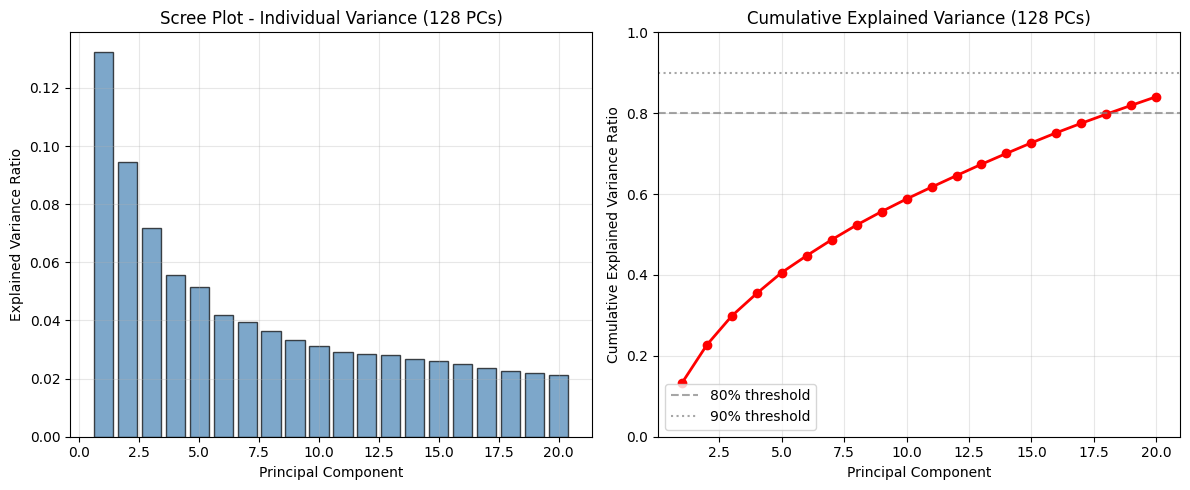

Variance explained by first 3 PCs: 0.299
Variance explained by first 5 PCs: 0.406
Variance explained by first 10 PCs: 0.588


In [5]:
# Create new PCA with 128 dimensions
pca_128 = PCA(n_components=20)
year_pca_128 = pca_128.fit_transform(year_embeddings)

# Create scree plot for 128-dimensional PCA
explained_variance_ratio = pca_128.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Individual explained variance
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
        alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot - Individual Variance (128 PCs)')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'o-', color='red', linewidth=2, markersize=6)
ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='80% threshold')
ax2.axhline(y=0.9, color='gray', linestyle=':', alpha=0.7, label='90% threshold')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance (128 PCs)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print variance explained by first few components
print(f"Variance explained by first 3 PCs: {cumulative_variance[2]:.3f}")
print(f"Variance explained by first 5 PCs: {cumulative_variance[4]:.3f}")
print(f"Variance explained by first 10 PCs: {cumulative_variance[9]:.3f}")


In [6]:
year_matrix = np.stack([e.numpy() for e in year_embeddings])

In [7]:
from sklearn.manifold import Isomap

# Assuming year_embeddings is the variable holding the embeddings
isomap = Isomap(n_components=1)
year_isomap_1d = isomap.fit_transform(year_matrix)

from scipy.stats import kendalltau

# Flatten the isomap embedding to a 1D array
isomap_1d_flat = year_isomap_1d[:, 0]

# Perform Kendall's tau test between the year order and the isomap order
tau, p_value = kendalltau(years, isomap_1d_flat)

print(f"Kendall's tau correlation between year and Isomap 1D embedding: {tau:.4f}")
print(f"P-value: {p_value:.4e}")


colorscale_max = '#EA5526'
colorscale_min = '#4462bd'

import plotly.graph_objects as go
import plotly.express as px

# Create custom colorscale for plotly
custom_colorscale = [[0, colorscale_min], [1, colorscale_max]]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=years,
    y=year_isomap_1d[:, 0],
    mode='markers',
    marker=dict(
        color=years,
        colorscale=custom_colorscale,
        size=8,
        colorbar=dict(
            title=dict(
                text='Year',
                font=dict(family='Junicode, serif', size=14, color='black')
            ),
            tickfont=dict(family='Geist Mono', size=12, color='black'),
            x=1.02
        )
    ),
    hovertemplate='<span style="font-family: Geist Mono;">Year: %{x}<br>Isomap1D: %{y:.4f}</span><extra></extra>',
    showlegend=False
))

fig.update_layout(
    xaxis=dict(
        title=dict(
            text='Year',
            font=dict(family='Junicode, serif', size=18, color='black')
        ),
        tickfont=dict(family='Geist Mono', size=14, color='black'),
        showgrid=False,
        linecolor='black',
        zeroline=False
    ),
    yaxis=dict(
        title=dict(
            text='Isomap Embedding',
            font=dict(family='Junicode, serif', size=18, color='black')
        ),
        tickfont=dict(family='Geist Mono', size=14, color='black'),
        showgrid=False,
        linecolor='black',
        zeroline=False
    ),
    width=1000,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

# Add Kendall's tau annotation
fig.add_annotation(
    x=0.05,
    y=0.90,
    xref='paper',
    yref='paper',
    text=f"Kendall's τ = {tau:.2f}<br>p = {p_value:.2e}",
    showarrow=False,
    font=dict(family='Geist Mono', size=14, color='black'),
    align='left',
    valign='top'
)

# Save as HTML

config = {'displayModeBar': False}
fig.write_html("year_manifold_isomap.html", config=config)

fig.show()


Kendall's tau correlation between year and Isomap 1D embedding: 0.9816
P-value: 3.0480e-28


In [8]:
from umap import UMAP

# Assuming year_embeddings is the variable holding the embeddings
umap_reducer = UMAP(n_components=1, random_state=42, n_neighbors=7, metric='euclidean')
year_umap_1d = umap_reducer.fit_transform(year_matrix)

from scipy.stats import kendalltau

# Flatten the umap embedding to a 1D array
umap_1d_flat = year_umap_1d[:, 0]

# Perform Kendall's tau test between the year order and the umap order
tau, p_value = kendalltau(years, umap_1d_flat)

print(f"Kendall's tau correlation between 1D covariate and UMAP 1D embedding: {tau:.4f}")
print(f"P-value: {p_value:.4e}")


colorscale_max = '#EA5526'
colorscale_min = '#4462bd'

import plotly.graph_objects as go
import plotly.express as px

# Create custom colorscale for plotly
custom_colorscale = [[0, colorscale_min], [1, colorscale_max]]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[e - 1990 for e in years],
    y=-1 * year_umap_1d[:, 0],
    mode='markers',
    marker=dict(
        color=[e - 1990 for e in years],
        colorscale=custom_colorscale,
        size=8,
        colorbar=dict(
            title=dict(
                text='Covariate Value',
                font=dict(family='Junicode, serif', size=14, color='black')
            ),
            tickfont=dict(family='Geist Mono', size=12, color='black'),
            x=1.02
        )
    ),
    hovertemplate='<span style="font-family: Geist Mono;">Year: %{x}<br>UMAP1D: %{y:.4f}</span><extra></extra>',
    showlegend=False
))

fig.update_layout(
    xaxis=dict(
        title=dict(
            text='Covariate',
            font=dict(family='Junicode, serif', size=18, color='black')
        ),
        tickfont=dict(family='Geist Mono', size=14, color='black'),
        showgrid=False,
        linecolor='black',
        zeroline=False
    ),
    yaxis=dict(
        title=dict(
            text='UMAP Embedding',
            font=dict(family='Junicode, serif', size=18, color='black')
        ),
        tickfont=dict(family='Geist Mono', size=14, color='black'),
        showgrid=False,
        linecolor='black',
        zeroline=False
    ),
    width=1000,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

# Add Kendall's tau annotation
fig.add_annotation(
    x=0.05,
    y=0.90,
    xref='paper',
    yref='paper',
    text=f"Kendall's τ = {tau:.2f}<br>p = {p_value:.2e}",
    showarrow=False,
    font=dict(family='Geist Mono', size=14, color='black'),
    align='left',
    valign='top'
)

# Save as HTML

config = {'displayModeBar': False}
fig.write_html("year_manifold_umap.html", config=config)

fig.show()


/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Kendall's tau correlation between 1D covariate and UMAP 1D embedding: -0.8897
P-value: 3.9985e-18


Saved paper figure to year_manifold_paper_figure.png


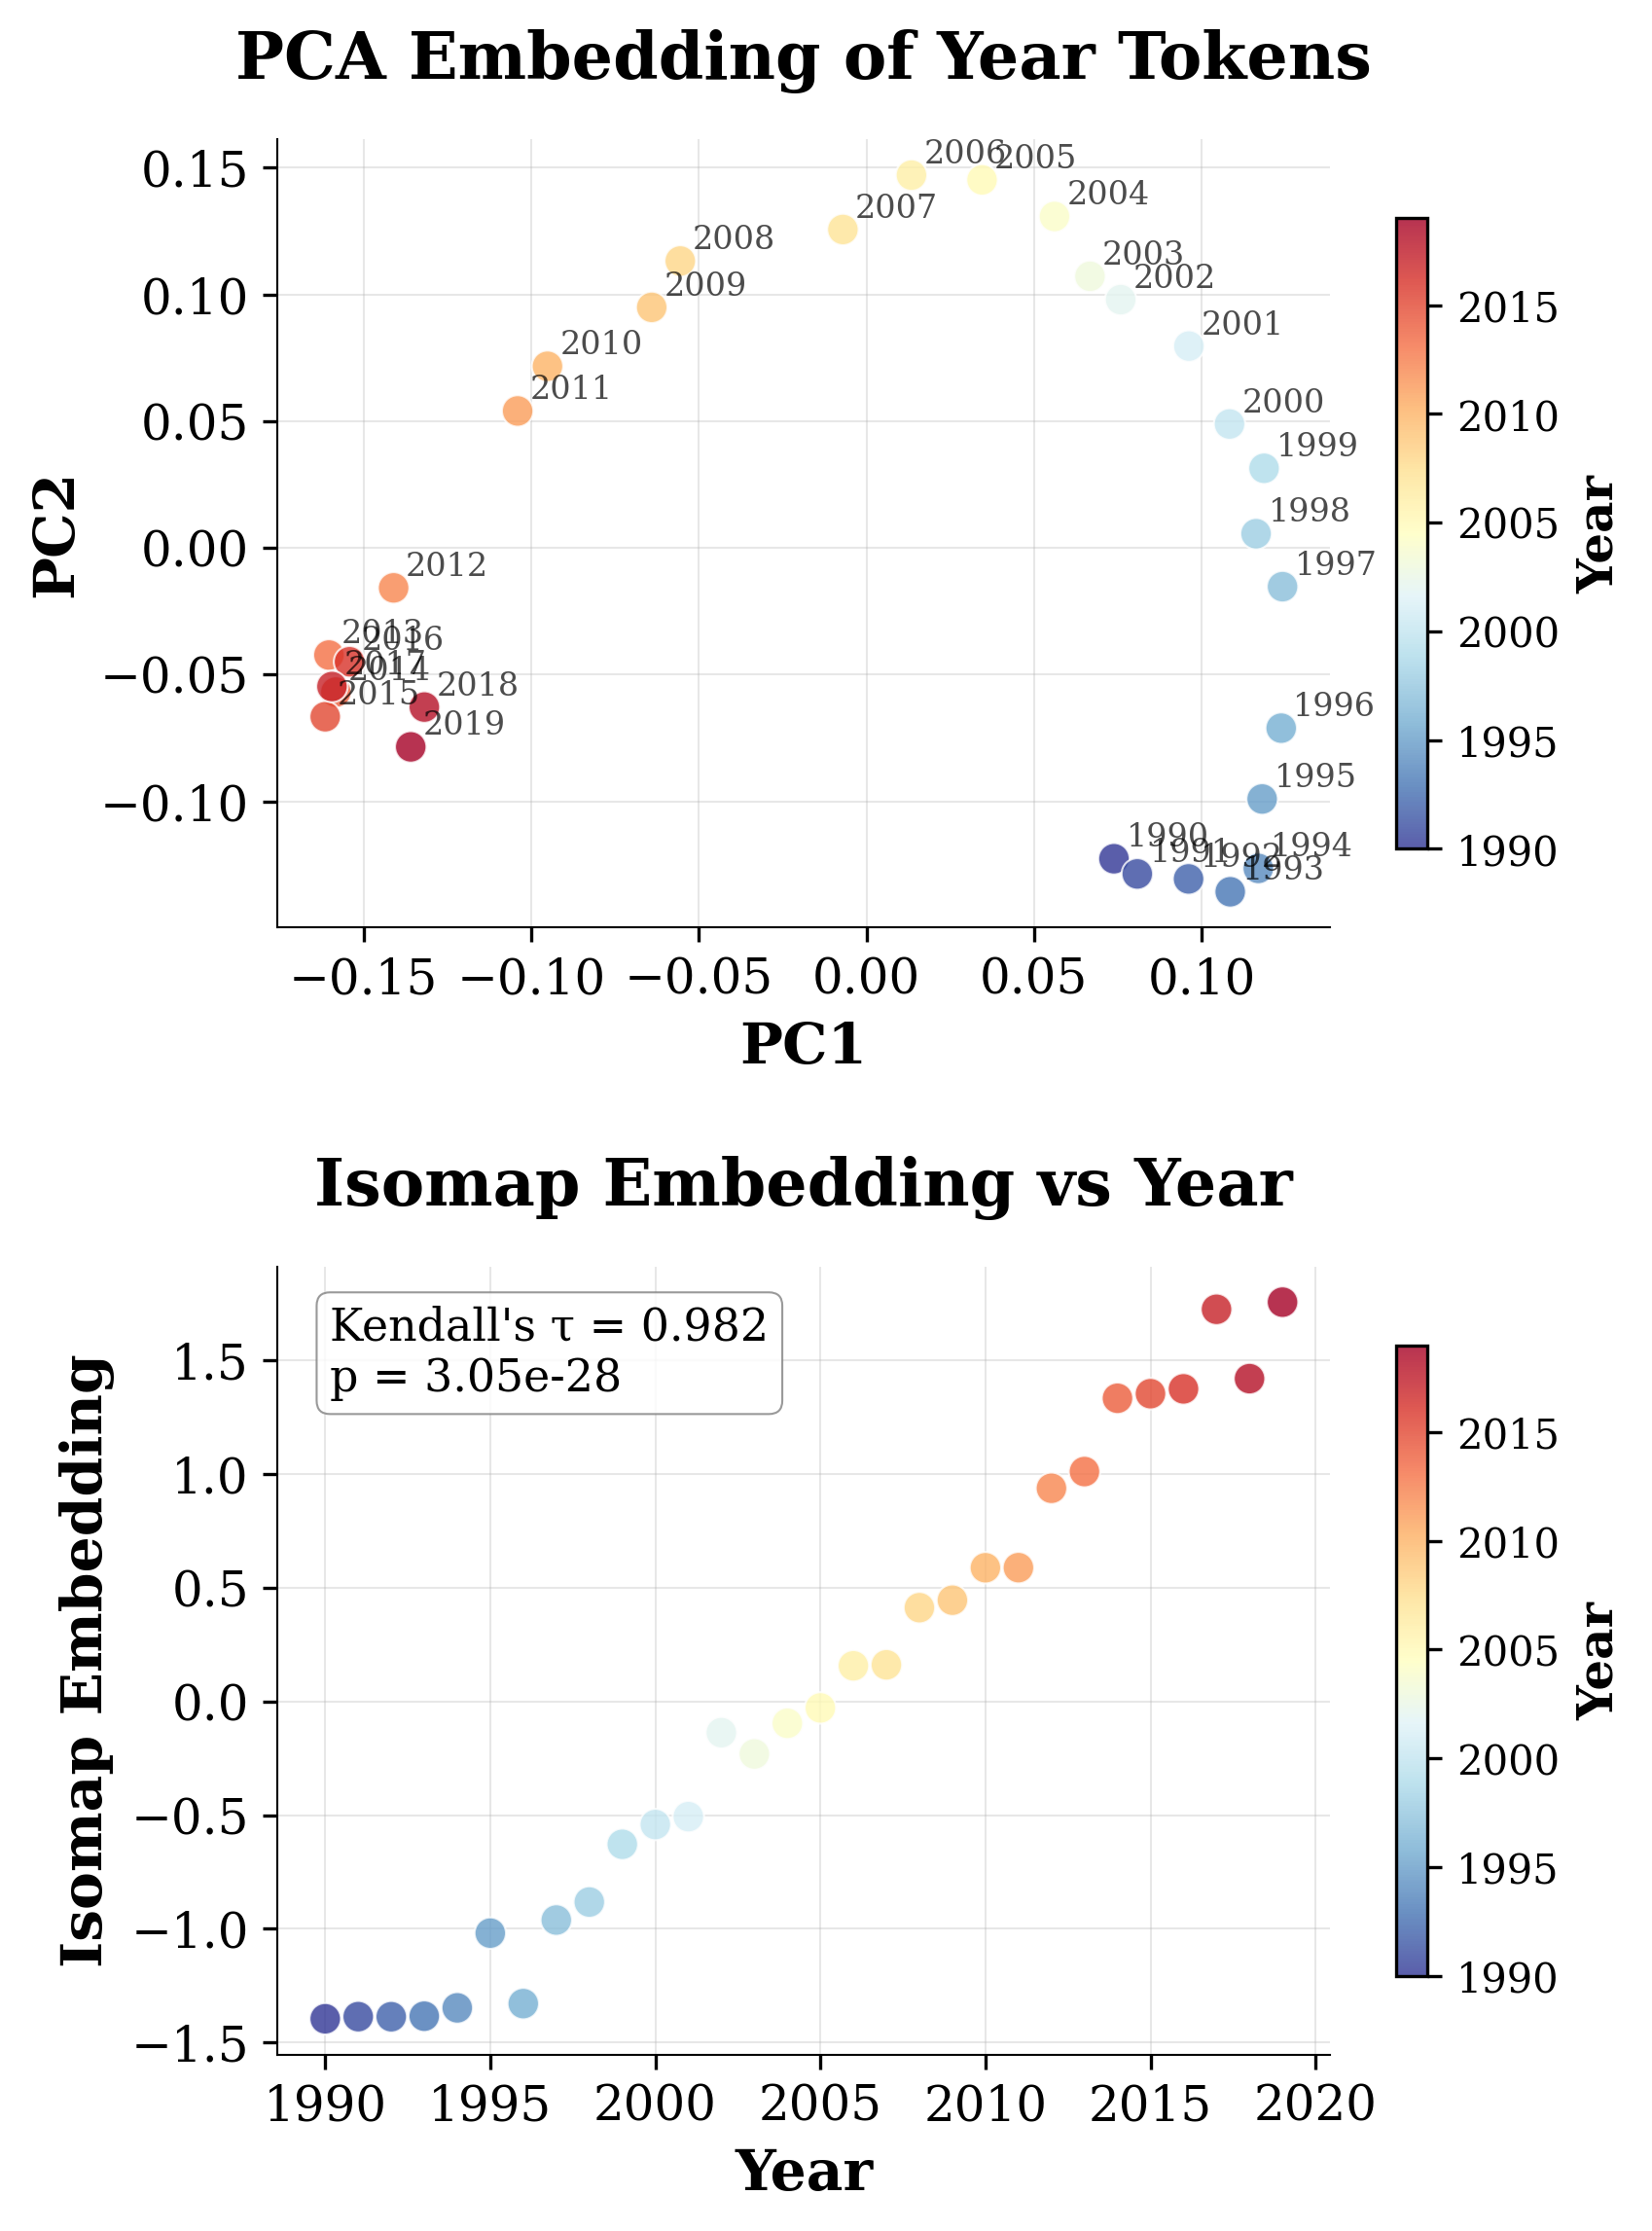

In [9]:
def create_paper_figure(saveas=None):
    """
    Create a manuscript-ready figure with PCA embedding on top and Isomap vs year on bottom.
    Uses styling similar to visualize_process_small from climate_change.ipynb.
    
    Args:
        saveas: Optional filename to save PNG (without extension)
    """
    # Create figure with two subplots in single column layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), dpi=300)
    
    # Define colors consistent with other visualizations
    colorscale_max = '#EA5526'
    colorscale_min = '#4462bd'
    
    # Top subplot: PCA embedding (2D projection of first 2 components)
    scatter = ax1.scatter(year_pca[:, 0], year_pca[:, 1], 
                         c=years, cmap='RdYlBu_r', s=60, alpha=0.8, 
                         edgecolors='white', linewidth=0.5)
    
    # Add year labels to points
    for i, year in enumerate(years):
        ax1.annotate(str(year), (year_pca[i, 0], year_pca[i, 1]), 
                    xytext=(3, 3), textcoords='offset points', 
                    fontsize=8, fontfamily='serif', alpha=0.7)
    
    ax1.set_xlabel('PC1', fontfamily='serif', fontsize=14, fontweight='bold')
    ax1.set_ylabel('PC2', fontfamily='serif', fontsize=14, fontweight='bold')
    ax1.set_title('PCA Embedding of Year Tokens', fontfamily='serif', fontsize=16, fontweight='bold', pad=15)
    
    # Customize PCA plot appearance
    ax1.tick_params(axis='both', labelsize=12)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontfamily('serif')
    
    # Add colorbar for PCA plot
    cbar1 = plt.colorbar(scatter, ax=ax1, shrink=0.8)
    cbar1.set_label('Year', fontfamily='serif', fontsize=12, fontweight='bold')
    cbar1.ax.tick_params(labelsize=10)
    for label in cbar1.ax.get_yticklabels():
        label.set_fontfamily('serif')
    
    # Remove spines for cleaner look
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(0.5)
    ax1.spines['bottom'].set_linewidth(0.5)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    
    # Bottom subplot: Isomap vs Year
    scatter2 = ax2.scatter(years, year_isomap_1d[:, 0], 
                          c=years, cmap='RdYlBu_r', s=60, alpha=0.8,
                          edgecolors='white', linewidth=0.5)
    
    ax2.set_xlabel('Year', fontfamily='serif', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Isomap Embedding', fontfamily='serif', fontsize=14, fontweight='bold')
    ax2.set_title('Isomap Embedding vs Year', fontfamily='serif', fontsize=16, fontweight='bold', pad=15)
    
    # Customize Isomap plot appearance
    ax2.tick_params(axis='both', labelsize=12)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontfamily('serif')
    
    # Add colorbar for Isomap plot
    cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8)
    cbar2.set_label('Year', fontfamily='serif', fontsize=12, fontweight='bold')
    cbar2.ax.tick_params(labelsize=10)
    for label in cbar2.ax.get_yticklabels():
        label.set_fontfamily('serif')
    
    # Remove spines for cleaner look
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(0.5)
    ax2.spines['bottom'].set_linewidth(0.5)
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)
    
    # Add Kendall's tau annotation to Isomap plot
    from scipy.stats import kendalltau
    tau, p_value = kendalltau(years, year_isomap_1d[:, 0])
    ax2.text(0.05, 0.95, f"Kendall's τ = {tau:.3f}\np = {p_value:.2e}", 
             transform=ax2.transAxes, fontfamily='serif', fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', 
             facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5))
    
    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)
    
    # Save as PNG if filename provided
    if saveas:
        if not saveas.endswith('.png'):
            saveas += '.png'
        plt.savefig(saveas, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Saved paper figure to {saveas}")
    
    plt.show()

# Create the paper figure
create_paper_figure(saveas='year_manifold_paper_figure')
